# Import

In [ ]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=cc2b7ba3fc5cd9b91b7eab6223760e4b77d6bbf5929602b1e9e1f310bc55b2ca
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp #TFP needs TF>= 2.3
import time

tf.random.set_seed(1234)
np.random.seed(1234)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Setting

In [ ]:

x = symbols('x')
y = symbols('y')
z = symbols('z')
t = symbols('t')

a = v1 = v2 = k =1.0 # or a=4 ,v1=5 ,v2=10 ,k=1/4
c1 = 1 + v1/k ;c2 = -v1/v2;c3 = c2 - c1
g1 = g2 =0

u1 = a*x*y*(1-x)*(1-y)*(1-z)*exp(-t)
u2 = a*x*y*(1-x)*(1-y)*(c1 + c2*z + c3*z**2)*exp(-t)

f1 = diff(u1,t) - v1*( diff(u1,x,2) + diff(u1,y,2) + diff(u1,z,2))
f2 = diff(u2,t) - v2*( diff(u2,x,2) + diff(u2,y,2) + diff(u2,z,2))

u1 = lambdify((x,y,z,t),u1)
u2 = lambdify((x,y,z,t),u2)

f1 = lambdify((x,y,z,t),f1,'tensorflow')
f2 = lambdify((x,y,z,t),f2,'tensorflow')

# TrainingData & TestData

In [ ]:
def trainingdata(N_u,N_f,N_i,omga,u,interface):    

    x_range = omga[0]
    y_range = omga[1]
    z_range = omga[2]
    t_range = [0.,1.]

    all_X_u_train = []
    all_u_train = []

    # Initial Condition t=0 , x1_range[0]<= x1 <= x_range[1] , x2_range[0] <= x2 <= x2_range[1]
    lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[1],t_range[0]])
    initial_X = lb + (ub-lb)*lhs(4,N_u)
    initial_u = u(initial_X[:,0], initial_X[:,1], initial_X[:,2],initial_X[:,3]).reshape(-1,1)
    
    all_X_u_train.append(initial_X)
    all_u_train.append(initial_u)

    # BC_interface: x2 = x2_range[interface], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    lb = np.array([x_range[0],y_range[0],z_range[interface],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[interface],t_range[1]])
    X_i_train = lb + (ub-lb)*lhs(4,N_i) 

    # BC\I : 
    for i in range(2):
      lb = np.array([x_range[i],y_range[0],z_range[0],t_range[0]])
      ub = np.array([x_range[i],y_range[1],z_range[1],t_range[1]])
      BC_X = lb + (ub-lb)*lhs(4,N_u)
      BC_u = u(BC_X[:,0],BC_X[:,1],BC_X[:,2],BC_X[:,3]).reshape(-1,1) 
      all_X_u_train.append(BC_X)
      all_u_train.append(BC_u)
    for i in range(2):
      lb = np.array([x_range[0],y_range[i],z_range[0],t_range[0]])
      ub = np.array([x_range[1],y_range[i],z_range[1],t_range[1]])
      BC_X = lb + (ub-lb)*lhs(4,N_u)
      BC_u = u(BC_X[:,0],BC_X[:,1],BC_X[:,2],BC_X[:,3]).reshape(-1,1) 
      all_X_u_train.append(BC_X)
      all_u_train.append(BC_u) 
    
    lb = np.array([x_range[0],y_range[0],z_range[(interface+1)%2],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[(interface+1)%2],t_range[1]])
    BC_X = lb + (ub-lb)*lhs(4,N_u)
    BC_u = u(BC_X[:,0],BC_X[:,1],BC_X[:,2],BC_X[:,3]).reshape(-1,1) 
    all_X_u_train.append(BC_X)
    all_u_train.append(BC_u) 

    lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[1],t_range[1]])
    Inner_X = lb + (ub-lb)*lhs(4,N_u)
    Inner_u = u(Inner_X[:,0],Inner_X[:,1],Inner_X[:,2],Inner_X[:,3]).reshape(-1,1)
    all_X_u_train.append(Inner_X)
    all_u_train.append(Inner_u)

    all_X_u_train =  np.vstack(all_X_u_train)
    all_u_train = np.vstack(all_u_train)
    
    idx = np.random.choice(all_X_u_train.shape[0],all_X_u_train.shape[0], replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:]
            
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y,z,t)
    lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(4,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    return X_u_train,u_train,X_f_train,X_i_train

def ds_train_n_batch(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)
    batch_f1 = int(len(X_f1_train)/n)

    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)
    batch_f2 = int(len(X_f2_train)/n)
    
    batch_i = int(len(X_i_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    ds_f1 = tf.data.Dataset.from_tensor_slices( X_f1_train ).batch( batch_f1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    ds_f2 = tf.data.Dataset.from_tensor_slices( X_f2_train ).batch( batch_f2 )
    
    ds_i = tf.data.Dataset.from_tensor_slices(X_i_train).batch(batch_i)

    ds_train = tf.data.Dataset.zip((ds_u1,ds_f1,ds_u2,ds_f2,ds_i))
    return ds_train

def ds_test_n_batch(x1_test,u1_test,x2_test,u2_test,n=5):
  batch_u1 = int(len(u1_test)/n)
  batch_u2 = int(len(u2_test)/n)

  ds_u1 = tf.data.Dataset.from_tensor_slices( (x1_test,u1_test) ).batch(batch_u1)
  ds_u2 = tf.data.Dataset.from_tensor_slices( (x2_test,u2_test) ).batch(batch_u2)

  ds_test = tf.data.Dataset.zip((ds_u1,ds_u2))
  return ds_test

def test_data(N,omga,u):
  x_range = omga[0]
  y_range = omga[1]
  z_range = omga[2]
  t_range = [0.,1.]

  lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
  ub = np.array([x_range[1],y_range[1],z_range[1],t_range[1]])
  x_test = lb + (ub-lb)*lhs(4,N)
  u_test = u(x_test[:,0],x_test[:,1],x_test[:,2],x_test[:,3]).reshape((-1,1)) 

  return x_test,u_test

# Plot 

In [ ]:
omga1 = [[0.,1.],[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[0.,1.],[-1.,0.]] 
def plot_real_data(N,omga,u,t=1.0):
  # Output: X,Y,T,U shape=(N,N)
  x_range = tf.linspace(omga[0][0],omga[0][1],N)
  y_range = tf.linspace(omga[1][0],omga[1][1],N)
  z_range = tf.linspace(omga[2][0],omga[2][1],N)

  X,Y,Z = tf.meshgrid(x_range,y_range,z_range)
  T = tf.ones(shape=X.shape)*t
  U = u(X,Y,Z,T)
  return X,Y,Z,T,U

def plot_pred_data(X,Y,Z,T,model):
  #Input: X,Y,Z,T shape=(N,N)
  #Output: U_pred shape=(N,N)
  Shape = X.shape
  dim = len(Shape)
  X = tf.reshape(X,shape=(Shape[0]**dim,1))
  Y = tf.reshape(Y,shape=(Shape[0]**dim,1))
  Z = tf.reshape(Z,shape=(Shape[0]**dim,1))
  T = tf.reshape(T,shape=(Shape[0]**dim,1))

  Inputs = tf.concat([X,Y,Z,T],axis=1)
  U_pred = model(Inputs)
  U_pred = tf.reshape(U_pred,shape=Shape)
  return U_pred



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyparsing import col
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math

In [ ]:
def set_axes3D(axes:Axes3D,title:str):
    """设置 axes 的格式

    Args:
        axes (Axes3D): _description_
        title (str): _description_
    """
    #axes.set_box_aspect((3,1,3)) # 坐标轴缩放比例
    axes.set_xlim(0,1) #坐标轴范围
    axes.set_ylim(0,1)
    #axes.set_zlim(0,1)
    axes.set_xlabel('$x$',fontsize = 15, labelpad=-8.0) # 设置坐标轴标签
    axes.set_ylabel('$y$',fontsize = 15, labelpad=-3.0)
    axes.set_zlabel('$z$',fontsize = 15, labelpad= 2.0)
    axes.view_init(elev=30, azim=75) # 观察视角
    axes.tick_params(
        axis = 'x',
        which = 'major',
        pad = -4.5
    ) # 特殊设置，坐标轴标签位置调整
    axes.tick_params(
        axis = 'y',
        which = 'major',
        pad = -2.0
    )
    axes.tick_params(
        axis = 'both',
        which = 'major',
        direction = 'out',
        length = 1.0, 
        labelsize = 'small', #刻度标签的文字大小
    )
    # axes.xaxis.set_major_formatter('{x:.1f}s') # 还是不加单位了
    # axes.locator_params('x',nbins = 1,tight=True)
    axes.set_title(title,fontsize = 15) # 子图标题


In [ ]:
def plot3D_scatter(data_dict,colN = 4):
    
    figN = len(data_dict)
    rowN = math.ceil(figN /colN)
    
    subsize = [4.5,3] # 宽 高
    fig = plt.figure(figsize=(subsize[0] * colN, subsize[1] * rowN))

    for i,(key,datas) in enumerate(data_dict.items()):
        axes:Axes3D = fig.add_subplot(rowN, colN, i+1, projection='3d')
        set_axes3D(axes,key)
        img = axes.scatter(datas[0],datas[1],datas[2],
                           c = datas[3],
                           s=3,
                           cmap=plt.get_cmap('RdYlBu_r'),#'RdYlBu_r' 
                           alpha=0.8)

        fig.colorbar(img,ax=axes, shrink=0.6, format='%.2f')
        
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
    return fig

In [ ]:
def plot_Adam_history(history_saw_cp,start_epoch=0.05):

  fig = plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(211)
  epoches = len(history_saw_cp.history['loss'])
  start = int(epoches*start_epoch)
  x = np.arange(start,epoches,1)

  line1, = ax1.plot(x,history_saw_cp.history['loss'][start:],'g:')
  line2, = ax1.plot(x,history_saw_cp.history['loss_u1'][start:],'r:')
  line3, = ax1.plot(x,history_saw_cp.history['loss_u2'][start:],'b:')
  ax1.legend(handles=[line1,line2,line3],labels=['loss','loss_u1','loss_u2'])
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoches')
  ax1.autoscale()

  ax2 = fig.add_subplot(212)
  line4, = ax2.plot(x,history_saw_cp.history['val_err_u1'][start:],'r:')
  line5, = ax2.plot(x,history_saw_cp.history['val_err_u2'][start:],'b:')
  ax2.legend(handles=[line4,line5],labels=["err_u1","err_u2",])
  ax2.set_ylabel("error_rate")
  ax2.set_xlabel("epochs")
  ax2.autoscale()
  fig.suptitle("Adam")

  plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
  plt.show()

  fig.savefig("3d_parabolic_Adam_history.png")
  return fig

In [ ]:
def plot_Lbfgs_history(histroy,max_iterations):

  fig_lbfgs,ax = plt.subplots()
  ax.plot(histroy,'b:')
  ax.set_xlabel("num_objective_evaluations")
  ax.set_ylabel("loss")
  ax.set_title("L-BFGS Max_Iterations={}".format(max_iterations))
  
  plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
  plt.show()

  fig_lbfgs.savefig("3d_parabolic_lbfgs_history.png")
  return fig_lbfgs

# PINN Model

## Single PINN

In [ ]:
class MyPinn(keras.Sequential): 
    def __init__(self,Layers,v,n,f,name = None): 
        super(MyPinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],) ,dtype=tf.float64))
        for i in range(1,len(Layers)-1):
            self.add(keras.layers.Dense(Layers[i], dtype=tf.float64,
                kernel_regularizer=keras.regularizers.l2(0.01), 
                activity_regularizer=keras.regularizers.l1(0.01), 
                activation='tanh'))
        self.add(keras.layers.Dense(Layers[-1],dtype=tf.float64, name="outputs"))
        self.v0 = tf.constant(v,dtype=tf.float64)
        self.v = tf.Variable(0.50,dtype=tf.float64,trainable=True)

        self.n = tf.constant(n,dtype=tf.float64)
        self.f = f
 

    @tf.function
    def loss_U(self,X_u_train,u_train):
        u= self(X_u_train,training=True)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u
    #   
    @tf.function
    def loss_PDE(self,X_f_train):
        x = X_f_train[:,0:1]
        y = X_f_train[:,1:2]
        z = X_f_train[:,2:3]
        t = X_f_train[:,3:4]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x,y,z,t])
            X = tf.stack([x[:,0],y[:,0],z[:,0],t[:,0]],axis=1)
            u = self(X,training=True)  
            u_x = tape.gradient(u,x)
            u_y = tape.gradient(u,y)
            u_z = tape.gradient(u,z)
               
        u_t = tape.gradient(u, t)     
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
        u_zz = tape.gradient(u_z, z)

        del tape
      
        loss_f = u_t - self.v *(u_xx + u_yy + u_zz) - self.f(x,y,z,t)
        loss_f = tf.reduce_mean(tf.square(loss_f))
        return loss_f
    """以下为单区域PINN 训练方法"""    
    @tf.function
    def train_step(self,X_u_train,u_train,X_f_train):
      with tf.GradientTape() as tape:
        loss = self.loss_U(X_u_train,u_train) + self.loss_PDE(X_f_train)
      gradients = tape.gradient(loss,self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

      return loss

    def train(self,X_u_train,u_train,X_f_train,epochs=200):
      for epoch in tf.range(1,epochs+1):
          loss = self.train_step(X_u_train,u_train,X_f_train)
          if epoch % 50 == 0:                
              tf.print(
                  "Training loss (for per 50 epoches) at epoch ",epoch,":",loss
              )

## Couple PINN

In [ ]:
class CoupledPinnLoss(keras.losses.Loss):
  def __init__(self,model,name="pinn_loss"):
      super().__init__(name=name)
      self.model = model
  def __call__(self,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train):
  
    loss_u1_U = self.model.m1.loss_U(X_u1_train,u1_train)
    loss_u2_U = self.model.m2.loss_U(X_u2_train,u2_train) 
    loss_u1_PDE = self.model.m1.loss_PDE(X_f1_train)
    loss_u2_PDE = self.model.m2.loss_PDE(X_f2_train)
    loss_u1_I, loss_u2_I = self.model.loss_I(X_i_train)

    loss_u1_total = loss_u1_U + loss_u1_PDE + loss_u1_I
    loss_u2_total = loss_u2_U + loss_u2_PDE + loss_u2_I
    loss_i = loss_u1_I + loss_u2_I

    loss = loss_u1_total + loss_u2_total
    return loss,loss_u1_total,loss_u2_total,loss_i


In [ ]:
class CouplePinn(keras.Model):
  def __init__(self,model_u1,model_u2,k,name=None):
    super(CouplePinn,self).__init__(name=name)
    self.m1 = model_u1 
    self.m2 = model_u2
    self.k0 = tf.constant(k,dtype=tf.float64)
    self.k = tf.constant(k,dtype=tf.float64)

    # Metrics
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.loss_u1 = keras.metrics.Mean(name="loss_u1")
    self.loss_u2 = keras.metrics.Mean(name="loss_u2")
    self.loss_i = keras.metrics.Mean(name="loss_i")
    self.v1_tracker = keras.metrics.Mean(name="v1")
    self.v2_tracker = keras.metrics.Mean(name="v2")

    self.u1_error = keras.metrics.Mean(name="err_u1")
    self.u2_error = keras.metrics.Mean(name="err_u2")
    
  @property
  def metrics(self):
      # We list our `Metric` objects here so that `reset_states()` can be
      # called automatically at the start of each epoch
      # or at the start of `evaluate()`.
      # If you don't implement this property, you have to call
      # `reset_states()` yourself at the time of your choosing.
      m = [self.loss_tracker,
           self.loss_u1,
           self.loss_u2,
           #self.loss_i,
           self.v1_tracker,
           self.v2_tracker,
           self.u1_error,
           self.u2_error]
      return m 

  """ 交界处损失函数 """
  @tf.function
  def loss_I(self,X_i_train):
      x = X_i_train[:,0:1]
      y = X_i_train[:,1:2]
      z = X_i_train[:,2:3]
      t = X_i_train[:,3:4]
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch([x,y,z,t])
          X = tf.stack([x[:,0],y[:,0],z[:,0],t[:,0]],axis=1)
          U1 = self.m1(X,training=True)
          U2 = self.m2(X,training=True)
      
      U1_x = tape.gradient(U1, x)
      U1_y = tape.gradient(U1, y)
      U1_z = tape.gradient(U1, z)
      U2_x = tape.gradient(U2, x)
      U2_y = tape.gradient(U2, y)
      U2_z = tape.gradient(U2, z)

      del tape
      
      loss_i1 = self.m1.v * ( U1_x*self.m1.n[0] + U1_y*self.m1.n[1] + U1_z*self.m1.n[2]) + self.k * (U1-U2)
      loss_i2 = self.m2.v * ( U2_x*self.m2.n[0] + U2_y*self.m2.n[1] + U2_z*self.m2.n[2]) + self.k * (U2-U1)

      loss_i1 = tf.reduce_mean(tf.square(loss_i1)) 
      loss_i2 = tf.reduce_mean(tf.square(loss_i2))

      return loss_i1,loss_i2
      

  """耦合区域 PINN训练方法"""
  @tf.function
  def train_step(self,data):
      (X_u1_train,u1_train),X_f1_train,(X_u2_train,u2_train),X_f2_train,X_i_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss,loss_u1_total,loss_u2_total,loss_i = self.loss(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train)
      
      # Compute gradients
      #gradients = tape.gradient(loss,self.trainable_variables)

      gradients_u1 = tape.gradient(loss,self.m1.trainable_variables)
      gradients_u2 = tape.gradient(loss,self.m2.trainable_variables)

      del tape

      # Updata parameters
      #self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

      self.m1.optimizer.apply_gradients(zip(gradients_u1,self.m1.trainable_variables))
      self.m2.optimizer.apply_gradients(zip(gradients_u2,self.m2.trainable_variables))

      # Updata loss Metric
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_u1_total)
      self.loss_u2.update_state(loss_u2_total)
      self.loss_i.update_state(loss_i)
      self.v1_tracker.update_state(self.m1.v)
      self.v2_tracker.update_state(self.m2.v)

      metrics = {m.name : m.result() for m in self.metrics[:-2]}

      return metrics

  @tf.function
  def test_step(self,data):
    (x1_test,u1_test),(x2_test,u2_test) = data
    # Updata test Metric
    u1_pred = self.m1(x1_test)
    u2_pred = self.m2(x2_test)
    err_u1 = tf.linalg.norm(u1_test-u1_pred) / tf.linalg.norm(u1_test)
    err_u2 = tf.linalg.norm(u2_test-u2_pred) / tf.linalg.norm(u2_test)  

    self.u1_error.update_state(err_u1) 
    self.u2_error.update_state(err_u2)
    
    return {self.u1_error.name:self.u1_error.result(),
            self.u2_error.name:self.u2_error.result()}

## Self-Adaptive-Weight Couple PINN

In [ ]:
class SawCoupledPinnLoss(keras.losses.Loss):
  def __init__(self,model,name="saw_couple_pinn_loss"):
      super().__init__(name=name)
      self.model = model
  
  @tf.function
  def __call__(self,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train):
  
    loss_u1_U = self.model.m1.loss_U(X_u1_train,u1_train)
    loss_u2_U = self.model.m2.loss_U(X_u2_train,u2_train) 
    loss_u1_PDE = self.model.m1.loss_PDE(X_f1_train)
    loss_u2_PDE = self.model.m2.loss_PDE(X_f2_train)
    loss_u1_I, loss_u2_I = self.model.loss_I(X_i_train)

    loss = (10*loss_u1_U+loss_u1_PDE+loss_u1_I) + (10*loss_u2_U+loss_u2_PDE+loss_u2_I)
    #loss = (5*loss_u1_U+loss_u1_PDE+loss_u1_I) + self.model.alpha*(5*loss_u2_U+loss_u2_PDE+loss_u2_I)
    return loss,loss_u1_U,loss_u2_U,loss_u1_PDE,loss_u2_PDE,loss_u1_I,loss_u2_I

In [ ]:
class SawCouplePinn(CouplePinn):
  def __init__(self,model_u1,model_u2,k,name=None):
    super(SawCouplePinn,self).__init__(model_u1,model_u2,k,name=name)
    # Self-Adaptive-Weights    
    self.eps = tf.constant(1e-10,dtype=tf.float64)
    self.alpha = tf.Variable(1.0,dtype = tf.float64, trainable = False, name='alpha')
    self.reg = tf.keras.regularizers.L2(0.01)
  
  """Self-Adaptive-Weights 耦合PINN训练方法"""
  @tf.function
  def train_step(self,data):
  
      (X_u1_train,u1_train),X_f1_train,(X_u2_train,u2_train),X_f2_train,X_i_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss_adaptive,loss_u1_U,loss_u2_U,loss_u1_PDE,loss_u2_PDE,loss_u1_I,loss_u2_I =(
            self.loss(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train)
          )
          loss_adaptive += self.reg([self.m1.v,self.m2.v])

      loss_u1 = loss_u1_U + loss_u1_PDE + loss_u1_I
      loss_u2 = loss_u2_U + loss_u2_PDE + loss_u2_I
      loss = loss_u1 + loss_u2

      # update alpha
      self.alpha.assign(loss_u2/(loss_u1+self.eps)) 

      # Compute gradients
      #gradients = tape.gradient(loss_adaptive,self.trainable_variables)

      gradients_u1 = tape.gradient(loss_adaptive,self.m1.trainable_variables)
      gradients_u2 = tape.gradient(loss_adaptive,self.m2.trainable_variables)

      del tape

      # Update parameters
      #self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

      self.m1.optimizer.apply_gradients(zip(gradients_u1,self.m1.trainable_variables))
      self.m2.optimizer.apply_gradients(zip(gradients_u2,self.m2.trainable_variables))

      # Updata loss Metric
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_u1)
      self.loss_u2.update_state(loss_u2)
      self.loss_i.update_state(loss_u1_I + loss_u2_I)
      self.v1_tracker.update_state(self.m1.v)
      self.v2_tracker.update_state(self.m2.v)

      metrics = {m.name : m.result() for m in self.metrics[:-2]}

      return metrics

## function factory

In [ ]:
def function_factory(model,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,untrainable_nums=0):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a loss function in model
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    if untrainable_nums == 0:
      shapes = tf.shape_n(model.trainable_variables[:])
    else:
      shapes = tf.shape_n(model.trainable_variables[:-untrainable_nums])
    n_tensors = len(shapes)
    trainable_nums = n_tensors

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
          n = np.product(shape)
          idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
          part.extend([i]*n)
          count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        
        # update the parameters in the model
        assign_new_model_parameters(params_1d)
        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            
            # calculate the loss
            loss_total = model.loss(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train)[0]

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_total, model.trainable_variables[:trainable_nums])
        grads = tf.dynamic_stitch(idx, grads)

        del tape

        # print out iteration & loss
        f.num_objective_evaluations.assign_add(1)
        if (f.num_objective_evaluations % 50 == 0) :
          tf.print("num_objective_evaluations:", f.num_objective_evaluations,
                   "loss:",loss_total,"v1:",model.m1.v,"v2:",model.m2.v)

        # store loss value and k so we can retrieve later
        tf.py_function(f.loss_history.append, inp=[loss_total], Tout=[])
        tf.py_function(f.v_history.append, inp=[(model.m1.v,model.m2.v)], Tout=[])

        return loss_total, grads

    # store these information as members so we can use them outside the scope
    f.num_objective_evaluations = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.loss_history = []
    f.v_history = []
    f.count = count

    return f

In [ ]:
def function_factory_separate(model,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,untrainable_nums=0):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a loss function in model
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = [tf.shape_n(model.m1.trainable_variables),tf.shape_n(model.m2.trainable_variables)]
    n_tensors = [len(shapes[0]),len(shapes[1])]

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = [0,0]
    idx = [[],[]] # stitch indices
    part = [[],[]] # partition indices

    for i,shapes_i in enumerate(shapes):
      for j, shape in enumerate(shapes_i):
          n = np.product(shape)
          idx[i].append(tf.reshape(tf.range(count[i], count[i]+n, dtype=tf.int32), shape))
          part[i].extend([j]*n)
          count[i] += n

    part = [ tf.constant(part[0]), tf.constant(part[1]) ]

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        count0 = count[0]
        count1 = count[1]

        params0 = tf.dynamic_partition(params_1d[0:count0], part[0], n_tensors[0])
        for i, (shape, param) in enumerate(zip(shapes[0], params0)):
            model.m1.trainable_variables[i].assign(tf.reshape(param, shape))
        
        params1 = tf.dynamic_partition(params_1d[count0:count0+count1], part[1], n_tensors[1])
        for i, (shape, param) in enumerate(zip(shapes[1], params1)):
            model.m2.trainable_variables[i].assign(tf.reshape(param, shape))
        '''
        num = 0
        for k in tf.range(0,2):
          params = tf.dynamic_partition(params_1d[num:num+count[k]], part[k], n_tensors[k])
          for i, (shape, param) in enumerate(zip(shapes, params)):
            model.m[k].trainable_variables[i].assign(tf.reshape(param, shape))
          num += count[k]
        '''
    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        # update the parameters in the model
        assign_new_model_parameters(params_1d)
        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape(persistent=True) as tape:
            # calculate the loss
            loss_total = model.loss(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train)

        # calculate gradients and convert to 1D tf.Tensor
        grads_m1 = tape.gradient(loss_total, model.m1.trainable_variables)
        grads_m2 = tape.gradient(loss_total, model.m2.trainable_variables)

        grads_m1 = tf.dynamic_stitch(idx[0], grads_m1)
        grads_m2 = tf.dynamic_stitch(idx[1], grads_m2)

        grads = tf.concat([grads_m1,grads_m2],axis=0)
        
        del tape

        # print out iteration & loss
        f.num_objective_evaluations.assign_add(1)
        if (f.num_objective_evaluations % 50 == 0) :
          tf.print("num_objective_evaluations:", f.num_objective_evaluations,
                   "loss:",loss_total,"v1:",model.m1.v,"v2:",model.m2.v)

        # store loss value and k so we can retrieve later
        tf.py_function(f.loss_history.append, inp=[loss_total], Tout=[])
        tf.py_function(f.v_history.append, inp=[(model.m1.v,model.m2.v)], Tout=[])

        return loss_total, grads

    # store these information as members so we can use them outside the scope
    f.num_objective_evaluations = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.loss_history = []
    f.v_history = []
    f.count = count

    return f

# Train

In [ ]:
""" Training Data """
n1 = [0.,0.,-1.]
n2 = [0.,0.,1.]

omga1 = [[0.,1.],[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[0.,1.],[-1.,0.]] 


""" 参数反问题  v1=v2=1 """
N_i = 400

N_u1 = 800 ; N_f1 = 1000; omga = omga1; interface=0; u = u1 # Every bc has 800 points ,and stack to N_f
X_u1_train,u1_train,X_f1_train,X_i_train= trainingdata(N_u1,N_f1,N_i,omga,u,interface)


N_u2 = 800; N_f2 = 1000; omga = omga2; interface=1; u = u2
X_u2_train,u2_train,X_f2_train,X_i_train= trainingdata(N_u2,N_f2,N_i,omga,u,interface)


""" test Data """
N = 10000
x1_test,u1_test = test_data(N,omga1,u1)
x2_test,u2_test = test_data(N,omga2,u2)


""" DataSet  """
ds_train = ds_train_n_batch(X_u1_train, u1_train , X_f1_train , X_u2_train , u2_train , X_f2_train , X_i_train ,n = 10)
ds_test = ds_test_n_batch(x1_test,u1_test,x2_test,u2_test,n=1)

In [ ]:
Layers=[4,40,40,40,40,40,40,1]
#Layers=[4,400,200,50,1]
model_u1 = MyPinn(Layers,v1,n1,f1,name="model_u1")
model_u1.compile(optimizer=keras.optimizers.Adam())

model_u2 = MyPinn(Layers,v2,n2,f2,name="model_u2")
model_u2.compile(optimizer=keras.optimizers.Adam())


In [ ]:
saw_couple_model=SawCouplePinn(model_u1,model_u2,k,name="saw_couple_pinn");
saw_couple_model.compile( loss=SawCoupledPinnLoss(saw_couple_model),
          optimizer=keras.optimizers.Adam() )

In [ ]:
model_u1.train(X_u1_train,u1_train,X_f1_train,epochs=100) #单区域PINN训练
model_u2.train(X_u2_train,u2_train,X_f2_train,epochs=100) #单区域PINN训练

In [ ]:
history_saw_cp_1 = saw_couple_model.fit(ds_train,validation_data=ds_test,epochs=500) #saw耦合PINN训练 Adam

In [ ]:
saw_couple_model.save_weights("./ModelData/saw_couple_model_inverse_P/weights")

In [ ]:
func = function_factory(saw_couple_model,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train )

In [ ]:

params_1d = tf.dynamic_stitch(func.idx, saw_couple_model.trainable_variables[:])
## L-BFGS 优化阶段
max_iterations = 2000
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func,
    initial_position=params_1d, 
    num_correction_pairs=20, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    tolerance = 1*np.finfo(float).eps,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=max_iterations)

num_objective_evaluations: 50 loss: 0.00021629357475998721 v1: 1.5802598398209731 v2: 1.0599087809586252
num_objective_evaluations: 100 loss: 0.00021563538502098763 v1: 1.5790122824075596 v2: 1.059425514765725
num_objective_evaluations: 150 loss: 0.00021471220692751238 v1: 1.5774300443640092 v2: 1.0585858797273815
num_objective_evaluations: 200 loss: 0.00021330246881315324 v1: 1.573341695280051 v2: 1.0566287252622963
num_objective_evaluations: 250 loss: 0.00021202133672539497 v1: 1.5688782863690132 v2: 1.0543901438220324
num_objective_evaluations: 300 loss: 0.00021074232025172519 v1: 1.564062070287872 v2: 1.0520436998334586
num_objective_evaluations: 350 loss: 0.00020953571295086269 v1: 1.5595779020093703 v2: 1.0498077779791537
num_objective_evaluations: 400 loss: 0.00020828285601811496 v1: 1.5539542804275601 v2: 1.0472211316181312
num_objective_evaluations: 450 loss: 0.00020777691764816883 v1: 1.5521619014090655 v2: 1.0468470986124654
num_objective_evaluations: 500 loss: 0.00020538624

In [ ]:
fig_lbfgs = plot_Lbfgs_history(func.loss_history,max_iterations=max_iterations)

In [ ]:
saw_couple_model.evaluate(ds_test)


1/1 [==============================] - 0s 72ms/step - err_u1: 0.0406 - err_u2: 0.0240


[0.04057949781417847, 0.0239503625780344]

In [ ]:
'''
func_separate = function_factory_separate(saw_couple_model,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train )
params_1d = tf.dynamic_stitch(func_plus.idx, saw_couple_model.trainable_variables[:])
## L-BFGS 优化阶段
max_iterations = 2000
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func_separate,
    initial_position=params_1d, 
    num_correction_pairs=20, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    tolerance = 1*np.finfo(float).eps,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=max_iterations)
saw_couple_model.save_weights("./ModelData/saw_couple_model_inverse_P/weights")
'''

# Plotting

In [ ]:
""" Plot Data """
N = 20
X_u1,Y_u1,Z_u1,T_u1,U1 = plot_real_data(N,omga1,u1,t=1.0)
X_u2,Y_u2,Z_u2,T_u2,U2 = plot_real_data(N,omga2,u2,t=1.0)

U1_pred = plot_pred_data(X_u1,Y_u1,Z_u1,T_u1,model_u1)
U2_pred = plot_pred_data(X_u2,Y_u2,Z_u2,T_u2,model_u2)

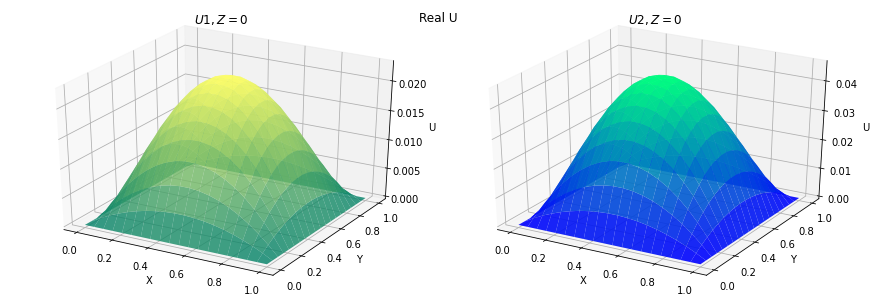

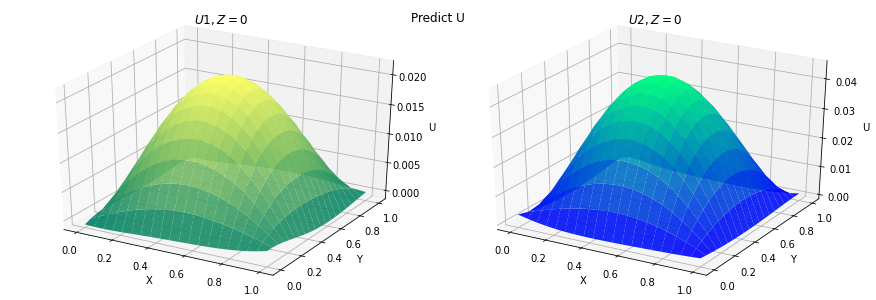

In [ ]:
####################################################
fig1=plt.figure(figsize=(12, 4)) 
fig1.suptitle("Real U")
ax11 = fig1.add_subplot(121,projection='3d')
ax11.plot_surface(X_u1[:,:,0],Y_u1[:,:,0],U1[:,:,0],alpha=0.8,cmap='summer')
#ax11.plot_surface(X_u1[:,:,5],Y_u1[:,:,5],Z_u1[:,:,5],facecolors=plt.cm.Oranges(U1[:,:,5]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调
#ax11.plot_surface(X_u1[:,:,-1],Y_u1[:,:,-1],Z_u1[:,:,-1],facecolors=plt.cm.Oranges(U1[:,:,-1]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调

#ax11.plot_surface(X_u1[:,0,:],Y_u1[:,0,:],Z_u1[:,0,:],facecolors=plt.cm.Oranges(U1[:,0,:]),alpha=0.8,) #alpha调节透明度，cmap调节曲面色调
#ax11.plot_surface(X_u1[:,-1,:],Y_u1[:,-1,:],Z_u1[:,0,:],facecolors=plt.cm.Oranges(U1[:,-1,:]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调

#ax11.plot_surface(X_u1[0,:,:],Y_u1[0,:,:],Z_u1[0,:,:],facecolors=plt.cm.Oranges(U1[0,:,:]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调
#ax11.plot_surface(X_u1[-1,:,:],Y_u1[-1,:,:],Z_u1[0,:,:],facecolors=plt.cm.Oranges(U1[-1,:,:]),alpha=0.8) #alpha调节透明度，cmap调节曲面色调

ax12 = fig1.add_subplot(122,projection='3d')
ax12.plot_surface(X_u2[:,:,-1],Y_u2[:,:,-1],U2[:,:,-1],alpha=0.9,cmap='winter')

ax11.set_xlabel("X")   
ax11.set_ylabel("Y")
ax11.set_zlabel("U")
ax11.set_title("$U1,Z=0$")

ax12.set_xlabel("X")   
ax12.set_ylabel("Y")
ax12.set_zlabel("U")
ax12.set_title("$U2,Z=0$")
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
fig1.savefig("3d_parabolic_surface_real.png")
###################################################### 
fig2 = plt.figure(figsize=(12, 4)) 
fig2.suptitle("Predict U")
ax21 = fig2.add_subplot(121,projection="3d")
ax22 = fig2.add_subplot(122,projection="3d")

### u1
ax21.plot_surface(X_u1[:,:,0],Y_u1[:,:,0],U1_pred[:,:,0],alpha=0.9,cmap='summer')
ax21.set_xlabel("X")   
ax21.set_ylabel("Y")
ax21.set_zlabel("U")
ax21.set_title("$U1,Z=0$")

### u2
ax22.plot_surface(X_u2[:,:,-1],Y_u2[:,:,-1],U2_pred[:,:,-1],alpha=0.9,cmap='winter')

ax22.set_xlabel("X")   
ax22.set_ylabel("Y")
ax22.set_zlabel("U")
ax22.set_title("$U2,Z=0$")
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
fig2.savefig("3d_parabolic_surface_pred_inverse_P.png")
###############################

plt.show()

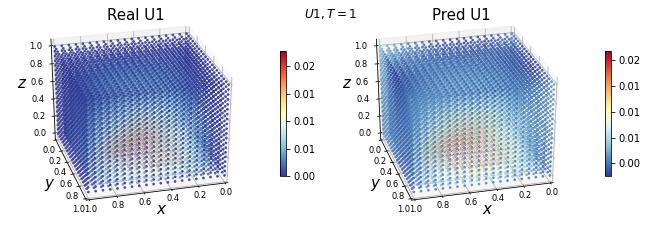

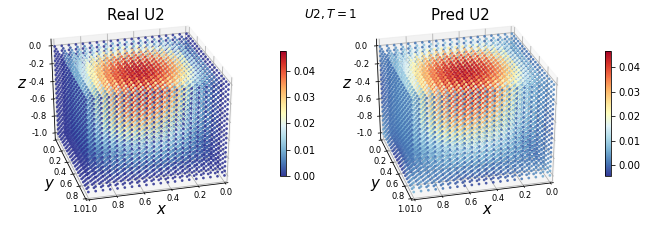

In [ ]:
u1_3D_data_dict = {
  'Real U1':[X_u1,Y_u1,Z_u1,U1],
  'Pred U1':[X_u1,Y_u1,Z_u1,U1_pred],
}
u2_3D_data_dict = {
  'Real U2':[X_u2,Y_u2,Z_u2,U2],
  'Pred U2':[X_u2,Y_u2,Z_u2,U2_pred],
}
fig1 = plot3D_scatter(u1_3D_data_dict,colN = 2)
fig1.suptitle("$U1,T=1$")
fig1.savefig("3d_parabolic_scatter_u1_inverse_P.png")
fig2 = plot3D_scatter(u2_3D_data_dict,colN = 2)
fig2.suptitle("$U2,T=1$")
fig2.savefig("3d_parabolic_scatter_u2_inverse_P.png")
plt.show()

# Save Model

In [ ]:
saw_couple_model.save_weights("./ModelData/saw_couple_model_inverse_P/weights")